In [203]:
from itertools import combinations
import numpy as np
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from ete3 import Tree
import io
from io import StringIO
import re

In [204]:
def hamming_distance(seq1, seq2):
    """Compute Hamming distance while ignoring missing base pairs (N or -)."""
    count = 0
    valid_sites = 0

    for c1, c2 in zip(seq1, seq2):
        if c1 in {'N', '-'} or c2 in {'N', '-'}:
            continue  # Ignore missing bases
        if c1 != c2:
            count += 1
        valid_sites += 1  # Count valid comparisons

    return count if valid_sites > 0 else 0  # Avoid division by zero

def construct_distance_matrix(genomes):
    """Construct a correctly formatted Biopython DistanceMatrix for UPGMA."""
    labels = list(genomes.keys())
    size = len(labels)

    matrix = []  # This will store the lower triangular part

    for i in range(size):
        row = []  # Each row should have exactly `i` elements (lower triangle)
        for j in range(i):  # j < i ensures lower-triangular format
            row.append(hamming_distance(genomes[labels[i]], genomes[labels[j]]))
        row.append(0)
        matrix.append(row)
        
    return labels, DistanceMatrix(names=labels, matrix=matrix)

def build_upgma_tree(genomes):
    """Build a phylogenetic tree using UPGMA."""
    labels, dist_matrix = construct_distance_matrix(genomes)
    constructor = DistanceTreeConstructor()
    tree = constructor.upgma(dist_matrix)
    return tree

def convert_biophylo_to_ete3(biophylo_tree):
    """Convert a Bio.Phylo tree to an ete3 Tree."""
    newick_str = io.StringIO()
    Phylo.write(biophylo_tree, newick_str, "newick")
    newick_str = newick_str.getvalue().strip()
    
    # Load the Newick string into an ete3 Tree
    ete3_tree = Tree(newick_str, format=1)
    
    for leaf in ete3_tree.iter_leaves():
        if leaf.name in species:
            leaf.name = species.index(leaf.name)
            
    return ete3_tree


def get_leaf_order(tree):
    """Returns the order of leaf nodes as they appear when plotting the UPGMA tree."""
    return [leaf.name for leaf in tree.get_terminals()]


def check_internal_nodes(tree, taxa_pairs):
    """Checks each internal node to see if it correctly splits the taxa pairs."""

    for node in tree.traverse('postorder'):
        if not node.is_leaf():
            left_leaves = set(node.children[0].get_leaf_names())
            right_leaves = set(node.children[1].get_leaf_names())
            
            compatable = False
            for t1, t2 in taxa_pairs:
                if (t1 in left_leaves and t2 in right_leaves) or (t2 in left_leaves and t1 in right_leaves):
                    compatable = True
                    break
            if not compatable:
                return False
                
    return True

DS2


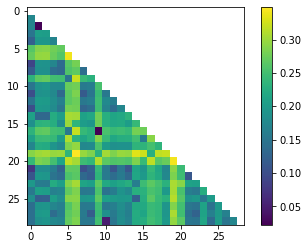

0.2138057026381094 0.05713694474664897


In [211]:
#datasets = ["DS1","DS2","DS3","DS4","DS5","DS6","DS7","DS8","DS9","DS10","DS11","DS14"]
#chars = ["C","A","G","T"]

ds = "DS2"
print(ds)

# load in genomes
data_file = '../dat/'+ds+'/'+ds+'.pickle'
with open(data_file, 'rb') as f:
    data = pickle.load(f)

genomes = []
species = []
for key in data:
    genomes.append(data[key])
    species.append(key)

ntaxa = len(species)

# plot hamming diatances
hdists = np.zeros((ntaxa,ntaxa))

for j in range(ntaxa):
    for k in range(j):
        hdists[j,k] = np.mean([(x != y) for x,y in zip(genomes[j],genomes[k]) if (x.upper() in ["C","A","G","T"]) and (y.upper() in ["C","A","G","T"])])

hdists[np.triu_indices(hdists.shape[0])] = np.nan
plt.imshow(hdists)
plt.colorbar()
plt.show()
print(np.nanmean(hdists),np.nanstd(hdists))

In [212]:
with open("../dat/"+ds+"/"+ds+"_MCC.tree", "r") as f:
    for line in f:
        if line.startswith("tree TREE1"):  # Ignore comments
            line = line[line.find('('):]
            newick_str = line.strip()
            break  # MCC trees usually contain only one tree

# Remove BEAST annotations (e.g., [&prob=0.99])
newick_cleaned = re.sub(r"\[&[^\]]*\]", "", newick_str)

MCC_tree = Tree(newick_cleaned, format=1)
print(MCC_tree)


            /-24
           |
         /-|      /-2
        |  |   /-|
        |  |  |   \-3
        |   \-|
        |     |   /-15
        |      \-|
        |         \-26
      /-|
     |  |      /-13
     |  |   /-|
     |  |  |   \-19
     |  |  |
     |  |  |      /-27
     |  |  |   /-|
     |   \-|  |  |   /-25
     |     |  |   \-|
     |     |  |     |   /-11
     |     |  |      \-|
     |     |  |         \-29
     |     |  |
     |      \-|      /-5
     |        |     |
     |        |   /-|   /-14
     |        |  |  |  |
     |        |  |   \-|      /-1
   /-|        |  |     |   /-|
  |  |        |  |     |  |   \-22
  |  |        |  |      \-|
  |  |         \-|        |   /-8
  |  |           |         \-|
  |  |           |            \-12
  |  |           |
  |  |           |   /-23
  |  |           |  |
  |  |            \-|      /-28
  |  |              |   /-|
  |  |               \-|   \-4
--|  |                 |
  |  |                  \-9
  |  |
  |  |    

In [213]:
# Get the leaf node order for plotting
leaf_order = [leaf.name for leaf in MCC_tree.iter_leaves()]
leaf_pairs = [(leaf_order[i],leaf_order[i+1]) for i in range(ntaxa-1)]
print("Leaf pairs:", leaf_pairs)

check_internal_nodes(MCC_tree,leaf_pairs)

Leaf pairs: [('24', '2'), ('2', '3'), ('3', '15'), ('15', '26'), ('26', '13'), ('13', '19'), ('19', '27'), ('27', '25'), ('25', '11'), ('11', '29'), ('29', '5'), ('5', '14'), ('14', '1'), ('1', '22'), ('22', '8'), ('8', '12'), ('12', '23'), ('23', '28'), ('28', '4'), ('4', '9'), ('9', '16'), ('16', '18'), ('18', '7'), ('7', '21'), ('21', '20'), ('20', '17'), ('17', '10'), ('10', '6')]


True

In [214]:
# load in BEAST trees
trees = []

for i in range(10):
    print(i)
    tree_file = "../dat/"+ds+"/"+ds+"_fixed_pop_MLL_%d.trees"%(i+1)
    with open(tree_file, "r") as file:
        for j,line in enumerate(file):
            if line.startswith("tree STATE"):
                line = line[line.find('('):]
                line = line.replace("[&rate=1.0]","")
                trees.append(Tree(line, format=1))

print(len(trees))

0
1
2
3
4
5
6
7
8
9
100010


In [215]:
compatables = []
for i,tree in enumerate(trees):
    if i % 10000 == 0:
        print(i/len(trees))
    compatables.append(check_internal_nodes(tree,leaf_pairs))

0.0
0.0999900009999
0.1999800019998
0.2999700029997
0.3999600039996
0.49995000499950004
0.5999400059994
0.6999300069993001
0.7999200079992
0.8999100089991001
0.9999000099990001


In [216]:
(len(compatables) - sum(compatables))/len(compatables)

0.15265473452654735